In [1]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import numpy as np
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
import seaborn as sns

c:\Users\cjong\Projects\education\kpmg2\KPMG_MTA_Data_Analysis\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
data = pd.read_csv('../data/consolidated_signals.csv')
data['date'] = pd.to_datetime(data['date'])
start_date = '2020-04-20'
end_date = '2023-03-16'
data = data[(data['date'] >= start_date) & (data['date'] <= end_date)]
data = pd.get_dummies(data, prefix=['weather'], columns=['weather'])
data
#rename for prophet requirement
data = data.rename(columns={"date": "ds", "ridership": "y"})

In [3]:
#check null values
print(data.isna().sum())

ds                                            0
y                                             0
barclays-center_event_occurred                0
blue-note-jazz-club_event_occurred            0
carnegie-hall_event_occurred                  0
total_comedy                                  0
total_events                                  0
total_film-screenings                         0
forest-hills-stadium_event_occurred           0
kings-theatre_event_occurred                  0
madison-square-garden_event_occurred          0
metlife-stadium_event_occurred                0
total_music                                   0
radio-city-music-hall_event_occurred          0
terminal-5_event_occurred                     0
the-bowery-ballroom_event_occurred            0
yankee-stadium_event_occurred                 0
nyc_holiday                                   0
high_temp                                     0
low_temp                                      0
weather_Broken clouds                   

In [4]:
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1059 entries, 50 to 1108
Data columns (total 40 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   ds                                          1059 non-null   datetime64[ns]
 1   y                                           1059 non-null   float64       
 2   barclays-center_event_occurred              1059 non-null   int64         
 3   blue-note-jazz-club_event_occurred          1059 non-null   int64         
 4   carnegie-hall_event_occurred                1059 non-null   int64         
 5   total_comedy                                1059 non-null   float64       
 6   total_events                                1059 non-null   float64       
 7   total_film-screenings                       1059 non-null   int64         
 8   forest-hills-stadium_event_occurred         1059 non-null   int64         
 9   kings-theatr

In [5]:
#slice the training period: 02.01.2022 – 03.02.2023 
fold7 = data[(data['ds'] >= "2022-02-01") & (data['ds'] <= "2023-03-02")]
#slice the testing period: 3.03.2023 – 03.16.2023
testing = data[(data['ds'] >= "2023-03-03") & (data['ds'] <= "2023-03-16")]

#grid search for smallest mape value

In [6]:
import itertools

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'holidays_prior_scale': [0.01, 10],
    'seasonality_mode':['additive', 'multiplicative']
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
mapes = []  # Store the RMSEs for each params here
forecast_list = []

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(fold7)  # Fit model with given params
    forecast = m.predict(testing)
    score = np.mean(np.abs((testing['y'].values - forecast['yhat'].values)/testing['y'].values))*100
    forecast['score'] = score
    mapes.append(score)
    forecast_list.append(forecast)

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['mape'] = mapes
print(tuning_results)

16:34:58 - cmdstanpy - INFO - Chain [1] start processing
16:34:58 - cmdstanpy - INFO - Chain [1] done processing
16:34:58 - cmdstanpy - ERROR - Chain [1] error: error during processing Unknown error
Optimization terminated abnormally. Falling back to Newton.
16:34:58 - cmdstanpy - INFO - Chain [1] start processing
16:34:58 - cmdstanpy - INFO - Chain [1] done processing
16:34:58 - cmdstanpy - INFO - Chain [1] start processing
16:34:58 - cmdstanpy - INFO - Chain [1] done processing
16:34:58 - cmdstanpy - ERROR - Chain [1] error: error during processing Unknown error
Optimization terminated abnormally. Falling back to Newton.
16:34:58 - cmdstanpy - INFO - Chain [1] start processing
16:34:59 - cmdstanpy - INFO - Chain [1] done processing
16:34:59 - cmdstanpy - INFO - Chain [1] start processing
16:34:59 - cmdstanpy - INFO - Chain [1] done processing
16:34:59 - cmdstanpy - ERROR - Chain [1] error: error during processing Unknown error
Optimization terminated abnormally. Falling back to Newto

    changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale   
0                     0.001                     0.01                  0.01  \
1                     0.001                     0.01                  0.01   
2                     0.001                     0.01                 10.00   
3                     0.001                     0.01                 10.00   
4                     0.001                     0.10                  0.01   
..                      ...                      ...                   ...   
59                    0.500                     1.00                 10.00   
60                    0.500                    10.00                  0.01   
61                    0.500                    10.00                  0.01   
62                    0.500                    10.00                 10.00   
63                    0.500                    10.00                 10.00   

   seasonality_mode       mape  
0          additive  12.260087

In [7]:
#get all "mape" values from grid search
tuning_results.sort_values('mape', ascending=True)

,changepoint_prior_scale,seasonality_prior_scale,holidays_prior_scale,seasonality_mode,mape
31,0.010,10.00,10.00,multiplicative,4.276879
29,0.010,10.00,0.01,multiplicative,4.276879
27,0.010,1.00,10.00,multiplicative,4.292428
25,0.010,1.00,0.01,multiplicative,4.292428
9,0.001,1.00,0.01,multiplicative,4.378206
...,...,...,...,...,...
51,0.500,0.01,10.00,multiplicative,17.806844
3,0.001,0.01,10.00,multiplicative,17.883747
1,0.001,0.01,0.01,multiplicative,17.883747
35,0.100,0.01,10.00,multiplicative,18.041446


In [8]:
min_score = min([df['score'].min() for df in forecast_list])
#get the most accurate prediction
acc_pre = pd.DataFrame([df for df in forecast_list if df['score'].min() == min_score][0])
acc_pre

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat,score
0,2023-03-03,3.063251e+06,3.015402e+06,3.776542e+06,3.063251e+06,3.063251e+06,0.113013,0.113013,0.113013,0.113013,0.113013,0.113013,0.0,0.0,0.0,3.409437e+06,4.276879
1,2023-03-04,3.064310e+06,1.896996e+06,2.661987e+06,3.064310e+06,3.064310e+06,-0.255947,-0.255947,-0.255947,-0.255947,-0.255947,-0.255947,0.0,0.0,0.0,2.280009e+06,4.276879
2,2023-03-05,3.065368e+06,1.444006e+06,2.196630e+06,3.065368e+06,3.065368e+06,-0.414945,-0.414945,-0.414945,-0.414945,-0.414945,-0.414945,0.0,0.0,0.0,1.793410e+06,4.276879
3,2023-03-06,3.066427e+06,2.712197e+06,3.487462e+06,3.066427e+06,3.066427e+06,0.014628,0.014628,0.014628,0.014628,0.014628,0.014628,0.0,0.0,0.0,3.111283e+06,4.276879
4,2023-03-07,3.067486e+06,3.190687e+06,3.953947e+06,3.067486e+06,3.067486e+06,0.166576,0.166576,0.166576,0.166576,0.166576,0.166576,0.0,0.0,0.0,3.578456e+06,4.276879
5,2023-03-08,3.068545e+06,3.270780e+06,4.068049e+06,3.068545e+06,3.068545e+06,0.195155,0.195155,0.195155,0.195155,0.195155,0.195155,0.0,0.0,0.0,3.667388e+06,4.276879
6,2023-03-09,3.069603e+06,3.258782e+06,4.037908e+06,3.069603e+06,3.069603e+06,0.181519,0.181519,0.181519,0.181519,0.181519,0.181519,0.0,0.0,0.0,3.626796e+06,4.276879
7,2023-03-10,3.070662e+06,3.031830e+06,3.806075e+06,3.070662e+06,3.070662e+06,0.113013,0.113013,0.113013,0.113013,0.113013,0.113013,0.0,0.0,0.0,3.417685e+06,4.276879
8,2023-03-11,3.071721e+06,1.872389e+06,2.669709e+06,3.071721e+06,3.071721e+06,-0.255947,-0.255947,-0.255947,-0.255947,-0.255947,-0.255947,0.0,0.0,0.0,2.285524e+06,4.276879
9,2023-03-12,3.072780e+06,1.422940e+06,2.180132e+06,3.072779e+06,3.072780e+06,-0.414945,-0.414945,-0.414945,-0.414945,-0.414945,-0.414945,0.0,0.0,0.0,1.797746e+06,4.276879


Plot the prediction with lowest MAPE value: 4.24%

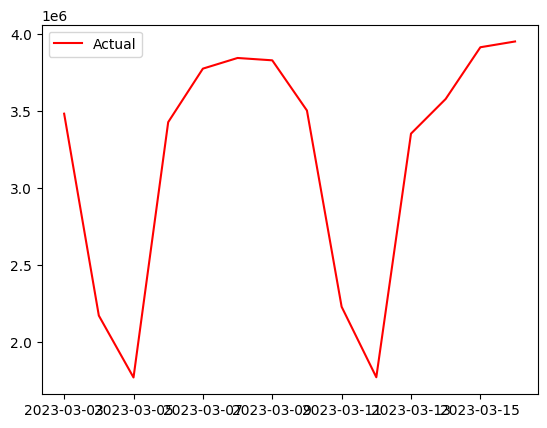

In [9]:
# plot only the forecast
dates = testing['ds']
plt.plot(dates,testing['y'],label = 'Actual',color = 'red')

# display the plot
plt.legend()
plt.show()

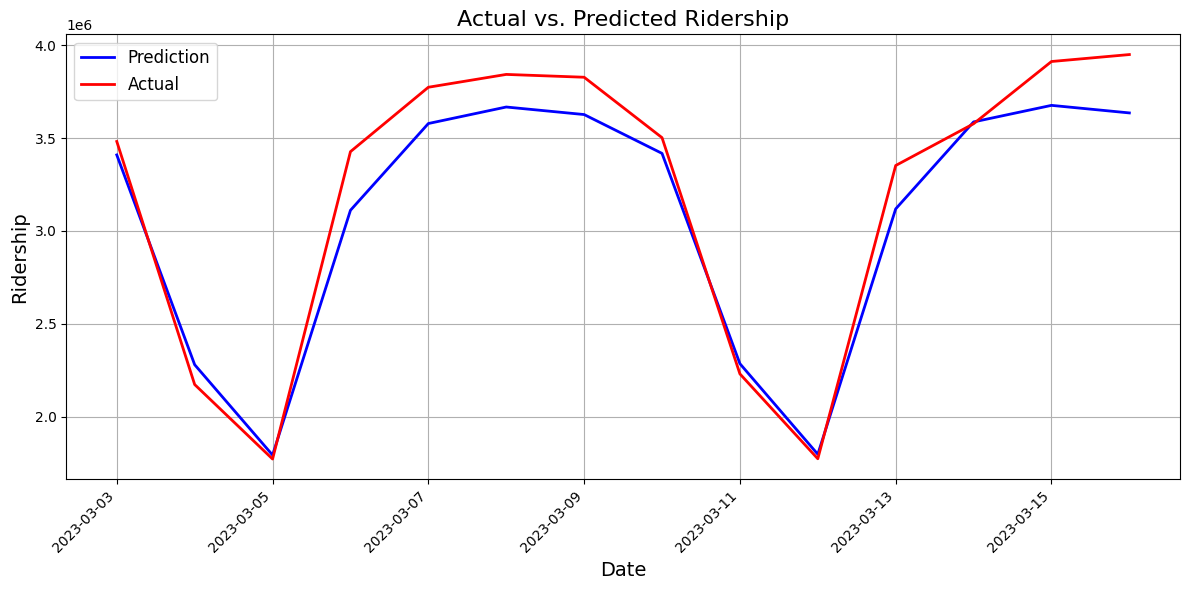

In [10]:
plt.figure(figsize=(12, 6))
# Plot only the forecast
plt.plot(dates, acc_pre['yhat'], label='Prediction', color='blue', linewidth=2)
plt.plot(dates, testing['y'], label='Actual', color='red', linewidth=2)

# Set the title and axis labels
plt.title('Actual vs. Predicted Ridership', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Ridership', fontsize=14)

# Add a grid and legend
plt.grid(True)
plt.legend(loc='upper left', fontsize=12)

# Customize the x-axis labels
plt.xticks(rotation=45, ha='right', fontsize=10)

# Display the plot
plt.tight_layout()
plt.show()


Get the distribution of MAPE values for each grid search combination

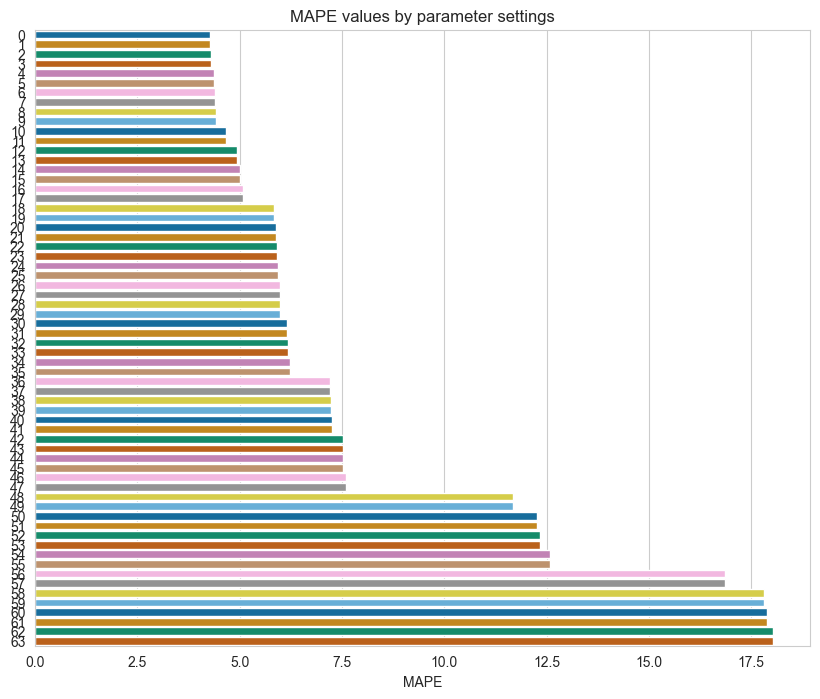

In [11]:
# Sort the dataframe by 'mape'
tuning_results_sorted = tuning_results.sort_values(by='mape',ascending =True).reset_index()

# Create a horizontal bar chart
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x='mape', y=tuning_results_sorted.index, data=tuning_results_sorted, ax=ax, palette='colorblind',orient='h')

# Add labels and a title
ax.set_xlabel('MAPE')
ax.set_ylabel('')
ax.set_title('MAPE values by parameter settings')

# Show the plot
plt.show()